In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
from pyswarm import pso
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()


In [9]:
df=pd.read_csv('preprocessed_dataset.csv')

C:\Users\Praveen\AppData\Local\Temp\ipykernel_10600\3254061002.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = df.replace(encode)


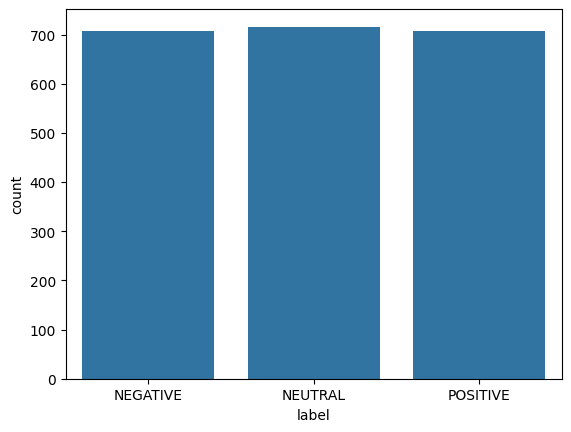

In [10]:
sns.countplot(x='label', data=df)

# df.isnull().sum().sum()

encode = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 0} )
df_encoded = df.replace(encode)

X=df_encoded.drop(["label"]  ,axis=1)
y = df_encoded.loc[:,'label'].values

In [11]:
X_orig=df_encoded.drop(["label"]  ,axis=1)
y_orig = to_categorical(df_encoded.loc[:,'label'].values)

In [12]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = to_categorical(y)
# print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0],1,X.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X.shape[1]))
print(f"X_train  shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(y_train.shape)  # Should be (num_samples, num_classes)
print(y_test.shape)


(1705, 2548)
X_train  shape: (1705, 1, 2548)
X_test  shape: (427, 1, 2548)
(1705, 2)
(427, 2)


In [13]:


# LSTM model creation with dynamic hyperparameters
def create_lstm_model(units1, units2, units3, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(int(units1), input_shape=(1, 2548), activation="relu", return_sequences=True),
        Dropout(dropout_rate),
        LSTM(int(units2), activation="relu", return_sequences=True),
        Dropout(dropout_rate),
        LSTM(int(units3), activation="relu"),
        Dropout(dropout_rate),
        Dense(2, activation='sigmoid')  # Assuming 3 output classes
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Objective function for PSO
def objective_function(params):
    units1, units2, units3, dropout_rate, learning_rate = params
    model = create_lstm_model(units1, units2, units3, dropout_rate, learning_rate)
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    score, acc = model.evaluate(X_test, y_test, verbose=0)
    
    # Minimize the negative accuracy (since PSO minimizes by default)
    return -acc

# Define PSO bounds for hyperparameters
lb = [32, 16, 8, 0.1, 0.0001]  # Lower bounds for units1, units2, units3, dropout_rate, learning_rate
ub = [128, 64, 32, 0.5, 0.01]  # Upper bounds for units1, units2, units3, dropout_rate, learning_rate

# Run PSO to optimize hyperparameters
best_params, best_score = pso(objective_function, lb, ub, swarmsize=10, maxiter=10)

# Print the best hyperparameters
print("Best hyperparameters found by PSO: ", best_params)
print("Best accuracy obtained during optimization: ", -best_score)

# Now you can train the model with the best hyperparameters found by PSO
best_units1, best_units2, best_units3, best_dropout_rate, best_learning_rate = best_params
best_model = create_lstm_model(best_units1, best_units2, best_units3, best_dropout_rate, best_learning_rate)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Evaluate the best model
score, acc = best_model.evaluate(X_test, y_test)
print(f"Accuracy after optimization: {acc}")

# Predict and calculate the confusion matrix
pred = best_model.predict(X_test)
predict_classes = np.argmax(pred, axis=1)
expected_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(expected_classes, predict_classes)
print("Confusion Matrix: \n", conf_matrix)


c:\Users\Praveen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 